# Importing Library

In [91]:
# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [92]:
pip install -U datasets

In [93]:
%%bash
pip install torch_optimizer numpy torch transformers evaluate python-whois --quiet
# The --quiet option is used to suppress the output of a pip command

In [94]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Import label encoder
from sklearn import preprocessing, metrics

import itertools
from sklearn.metrics import classification_report, mean_squared_error,confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
import random
import math
from collections import Counter
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import os
import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4
import os

# Data Understanding

In [95]:
df = pd.read_csv('/content/malicious_phish.csv')

### Dataset Information

In [96]:
print(df.shape)
print(df.info())

(226926, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226926 entries, 0 to 226925
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     226926 non-null  object
 1   type    226926 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB
None


In [97]:
df.groupby('type').apply(lambda x: x.sample(1)).reset_index(drop=True)

,url,type
0,content.usatoday.com/topics/more+articles/Kans...,benig
1,youtube.com/watch?v=Zv5TNtyqpfk,benign
2,http://www.wsnc.org.au/component/jcalpro/week/...,defacement
3,http://9779.info/%E5%BF%AB%E4%B9%90%E6%9A%91%E...,malware
4,http://tmalltops.com/redirect.htm?https://sign...,phishing


In [98]:
df.isna().sum()

,0
url,0
type,0


### Data Distribution

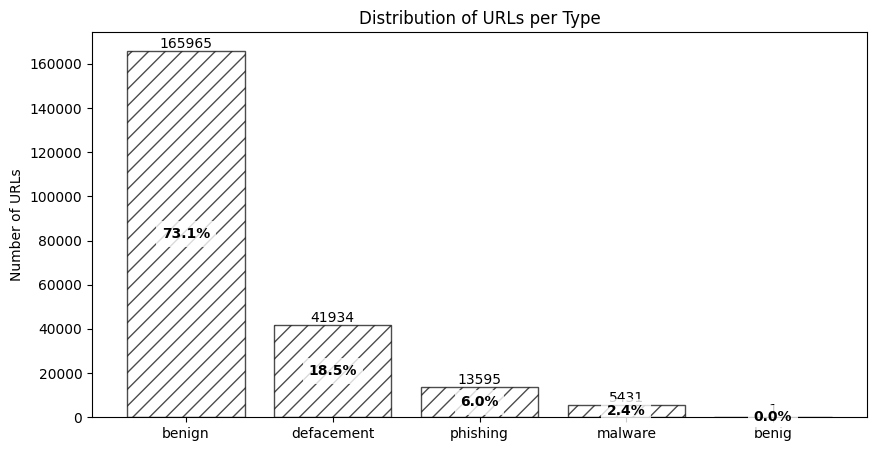

Counter({'benign': 165965, 'defacement': 41934, 'phishing': 13595, 'malware': 5431, 'benig': 1})


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

types = df['type'].values

counter_types = Counter(types)

type_names = list(counter_types.keys())
type_values = list(counter_types.values())

sorted_indices = np.argsort(type_values)[::-1]
type_names = [type_names[i] for i in sorted_indices]
type_values = [type_values[i] for i in sorted_indices]

total_count = sum(type_values)
percentages = [value / total_count * 100 for value in type_values]

pattern = '//'

y_pos = np.arange(len(type_names))
plt.figure(1, figsize=(10, 5))
bars = plt.bar(y_pos, type_values, align='center', alpha=0.7, color='none', edgecolor='black', hatch=pattern)

for bar, value, percentage in zip(bars, type_values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value}', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), fontweight='bold')

plt.xticks(y_pos, type_names)
plt.ylabel('Number of URLs')
plt.title('Distribution of URLs per Type')
plt.show()

print(counter_types)

In [100]:
df['url_len'] = [len(url) for url in df.url]
df.head()

,url,type,url_len
0,br-icloud.com.br,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235


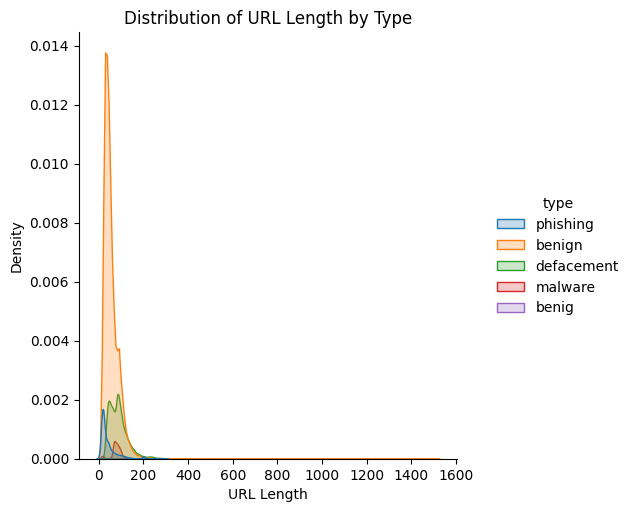

In [101]:
# Plot distribution of 'url_len' for each 'type'
sns.displot(df, x='url_len', hue='type', kind='kde', fill=True)

# Add labels and title
plt.xlabel('URL Length')
plt.ylabel('Density')
plt.title('Distribution of URL Length by Type')
plt.show()

# Data Preparation

## Label Encoding

In [102]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
le.fit(df["type"])

df["type_code"] = le.transform(df["type"])
df

,url,type,url_len,type_code
0,br-icloud.com.br,phishing,16,4
1,mp3raid.com/music/krizz_kaliko.html,benign,35,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,2
...,...,...,...,...
226921,filmaffinity.com/es/search.php?stype=cast&stex...,benign,60,1
226922,bennettashley.com,phishing,17,4
226923,fanpix.net/gallery/edie-mcclurg-pictures.htm,benign,44,1
226924,jigsaw.com/scid1547803/robert_dutrisac.xhtml,benign,44,1


In [103]:
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_label_mapping

{'benig': 0, 'benign': 1, 'defacement': 2, 'malware': 3, 'phishing': 4}

### Splitting
We need to make the data into huggingface dataset pyarrow format, since we gonna upload the dataset into huggingface hub

In [104]:
df = df[['url', 'type', 'type_code']]
dataset = Dataset.from_pandas(df, preserve_index=False)
dataset

Dataset({
    features: ['url', 'type', 'type_code'],
    num_rows: 226926
})

In [105]:
# split train to 80% of total and test to 20% of total
train_test_dataset = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 181540
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 45386
    })
})

In [106]:
# split the validation test to 10% of total and test set to 10% of total
val_test_dataset = train_test_dataset['test'].train_test_split(test_size=0.5, seed=42, shuffle=True)
val_test_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 22693
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 22693
    })
})

In [107]:
from datasets import DatasetDict

# 80% train, 10% validation, 10% test
dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'val': val_test_dataset['train'],
    'test': val_test_dataset['test'],
})
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 181540
    })
    val: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 22693
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 22693
    })
})

### Upload to Huggingface

In [108]:
# !pip install huggingface_hub

In [109]:
# from huggingface_hub import login
# login()

In [110]:
# dataset.push_to_hub('bgspaditya/byt-mal-minpro')

### Importing Huggingface Data

In [111]:
dataset = load_dataset("bgspaditya/byt-mal-minpro")
dataset = dataset.rename_column("type_code", "labels")
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 520952
    })
    val: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65120
    })
})

In [112]:
dataset = load_dataset("bgspaditya/byt-mal-minpro")
dataset = dataset.rename_column("type_code", "labels")
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 520952
    })
    val: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65120
    })
})

# Feature Engineering

In [113]:
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['val'])

## Check IP
To disguise the identity of a website, online criminals frequently use an Internet protocol address instead of the domain name server. This feature will determine if the URL contains an IP address or not

In [114]:
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df_train['use_of_ip'] = df_train['url'].apply(lambda i: having_ip_address(i))
df_test['use_of_ip'] = df_test['url'].apply(lambda i: having_ip_address(i))

df_train

,url,type,labels,use_of_ip
0,tools.ietf.org/html/rfc1328,phishing,3,0
1,twnty.com/,benign,0,0
2,pianoplus.ca/,benign,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0
...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0


## Abnormal URL
The WHOIS database may be used to extract this feature. Identity is commonly
included in the URL of a trustworthy website

In [115]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df_train['abnormal_url'] = df_train['url'].apply(lambda i: abnormal_url(i))
df_test['abnormal_url'] = df_test['url'].apply(lambda i: abnormal_url(i))
df_train

,url,type,labels,use_of_ip,abnormal_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0
1,twnty.com/,benign,0,0,0
2,pianoplus.ca/,benign,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0
...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1


## Count of dot (.)
The URLs of phishing or malware websites frequently contain more than two subdomains. A dot separates each domain (.). Every URL with more than three dot characters (.)
raises the risk of a malicious website

In [116]:
df_train['count.'] = df_train['url'].apply(lambda i: i.count('.'))
df_test['count.'] = df_test['url'].apply(lambda i: i.count('.'))

df_train.head()

,url,type,labels,use_of_ip,abnormal_url,count.
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2
1,twnty.com/,benign,0,0,0,1
2,pianoplus.ca/,benign,0,0,0,1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3


## Count of WWW (www.)
The majority of secure websites typically only contain one www in their URLs. If
the URL has no www or more than one www, this feature aids in the detection of fraudulent
websites.

In [117]:
df_train['count-www'] = df_train['url'].apply(lambda i: i.count('www'))
df_test['count-www'] = df_test['url'].apply(lambda i: i.count('www'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0
1,twnty.com/,benign,0,0,0,1,0
2,pianoplus.ca/,benign,0,0,0,1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0
...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0


## Count (@)
If the URL contains the "@" sign, everything before it is ignored

In [118]:
df_train['count@'] = df_train['url'].apply(lambda i: i.count('@'))
df_test['count@'] = df_test['url'].apply(lambda i: i.count('@'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0
1,twnty.com/,benign,0,0,0,1,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0
...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0


## Count Dir / URL Depth
Websites that have several directories in their URLs are typically suspect

In [119]:
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df_train['count_dir'] = df_train['url'].apply(lambda i: no_of_dir(i))
df_test['count_dir'] = df_test['url'].apply(lambda i: no_of_dir(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2
1,twnty.com/,benign,0,0,0,1,0,0,1
2,pianoplus.ca/,benign,0,0,0,1,0,0,1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7
...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2


## Count Embed Domain
Knowing how many embedded domains there are will help you spot
dangerous URLs. You may accomplish it by looking for the character "//" in the URL

In [120]:
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df_train['count_embed_domian'] = df_train['url'].apply(lambda i: no_of_embed(i))
df_test['count_embed_domian'] = df_test['url'].apply(lambda i: no_of_embed(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0


## Count Suspicious URL


In [121]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['sus_url'] = df_train['url'].apply(lambda i: suspicious_words(i))
df_test['sus_url'] = df_test['url'].apply(lambda i: suspicious_words(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0


## Count Shortening URL
This feature tells you whether a URL has been shortened using a service, such as bit.ly,
goo.gl, go2l.ink, etc

In [122]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['short_url'] = df_train['url'].apply(lambda i: shortening_service(i))
df_test['short_url'] = df_test['url'].apply(lambda i: shortening_service(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0


## Count HTTPS
Malicious Websites often avoid using HTTPS protocols since they typically demand
user login information and guarantee that online transactions are secure. Hence, whether HTTPS is
present or not is a key component of the URL.

In [123]:
df_train['count-https'] = df_train['url'].apply(lambda i : i.count('https'))
df_test['count-https'] = df_test['url'].apply(lambda i : i.count('https'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0


## Count HTTP
Safe websites typically have a single HTTP in their URL, but phishing or malicious
websites frequently have several HTTPs.

In [124]:
df_train['count-http'] = df_train['url'].apply(lambda i : i.count('http'))
df_test['count-http'] = df_test['url'].apply(lambda i : i.count('http'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1


## Count (%)
As we all know, spaces are not permitted in URLs. Normal URL encoding substitutes
the symbol (%) for spaces. Secure websites typically have less spaces in their URLs than
dangerous ones, which means that they have more spaces overall.

In [125]:
df_train['count%'] = df_train['url'].apply(lambda i: i.count('%'))
df_test['count%'] = df_test['url'].apply(lambda i: i.count('%'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0


## Count (-)
To make a Website appear legitimate, phishers and other cybercriminals frequently add
dashes (-) to the brand name's prefix or suffix. An illustration. www.flipkart-india.com.

In [126]:
df_train['count-'] = df_train['url'].apply(lambda i: i.count('-'))
df_test['count-'] = df_test['url'].apply(lambda i: i.count('-'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0


## Count (=)
The equal sign (=) in the URL denotes that variables are being sent from one form page
to another. As anybody may alter the values in a URL to change the page, it is regarded as being
riskier

In [127]:
df_train['count='] = df_train['url'].apply(lambda i: i.count('='))
df_test['count='] = df_test['url'].apply(lambda i: i.count('='))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1


## URL Length
To conceal the domain name, attackers frequently utilize lengthy URLs. We
discovered that a safe URL typically has a length of 74 characters

In [128]:
df_train['url_length'] = df_train['url'].apply(lambda i: len(str(i)))
df_test['url_length'] = df_test['url'].apply(lambda i: len(str(i)))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123


## Hostname Length
The hostname's length is a crucial element in identifying fraudulent URLs

In [129]:
df_train['hostname_length'] = df_train['url'].apply(lambda i: len(urlparse(i).netloc))
df_test['hostname_length'] = df_test['url'].apply(lambda i: len(urlparse(i).netloc))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length,hostname_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68,19
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100,7
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123,12


In [130]:
!pip install tld

## First Directory Length
With this feature, you may figure out how long the URL's first directory
is. In order to get the first directory length of the URL, check for the initial '/' and count the length
of the URL up to this point. Installing the Python TLD library is required to obtain directory-level
information. You may install TLD by visiting this page

In [131]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df_train['fd_length'] = df_train['url'].apply(lambda i: fd_length(i))
df_test['fd_length'] = df_test['url'].apply(lambda i: fd_length(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length,hostname_length,fd_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27,0,4
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68,19,18
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80,0,4
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100,7,8
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46,0,3
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123,12,7


## TLD Length
one of the domains at the top of the Internet's hierarchical domain
name system is a top-level domain (TLD). For instance, the top-level domain is com in the domain
name www.example.com. So, the length of the TLD is crucial for recognizing fraudulent URLs.
since.com is the most common extension for URLs. TLDs encompassing.

In [132]:
#Length of Top Level Domain
df_train['tld'] = df_train['url'].apply(lambda i: get_tld(i,fail_silently=True))
df_test['tld'] = df_test['url'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df_train['tld_length'] = df_train['tld'].apply(lambda i: tld_length(i))
df_test['tld_length'] = df_test['tld'].apply(lambda i: tld_length(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-https,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,0,27,0,4,None,-1
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,0,10,0,0,None,-1
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,0,13,0,0,None,-1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,0,1,0,3,0,68,19,18,dk,2
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,0,55,0,4,None,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,0,7,0,80,0,4,None,-1
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,0,1,0,12,0,100,7,8,com,3
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,0,6,0,46,0,3,None,-1
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,0,1,0,0,1,123,12,7,net,3


## Digit Count
Suspicious URLs are often those that contain numbers. Counting the amount of
digits in a URL is a key characteristic for identifying fraudulent URLs because safe URLs often
do not include digits

In [133]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df_train['count-digits']= df_train['url'].apply(lambda i: digit_count(i))
df_test['count-digits']= df_test['url'].apply(lambda i: digit_count(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length,count-digits
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,None,-1,4
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,None,-1,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,None,-1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,dk,2,9
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,None,-1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,7,0,80,0,4,None,-1,10
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,1,0,12,0,100,7,8,com,3,6
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,6,0,46,0,3,None,-1,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,1,0,0,1,123,12,7,net,3,33


## Letter Count
Another important factor in recognizing fraudulent URLs is the number of letters
in the URL. Attackers typically accomplish this by adding more letters and numbers to the URL in
an effort to lengthen it and conceal the domain name.

In [134]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df_train['count-letters']= df_train['url'].apply(lambda i: letter_count(i))
df_test['count-letters']= df_test['url'].apply(lambda i: letter_count(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,27,0,4,None,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,10,0,0,None,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,13,0,0,None,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,0,3,0,68,19,18,dk,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,55,0,4,None,-1,8,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,7,0,80,0,4,None,-1,10,57
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,0,12,0,100,7,8,com,3,6,75
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,6,0,46,0,3,None,-1,0,37
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,0,0,1,123,12,7,net,3,33,74


In [135]:
df_train = df_train.drop("tld",axis=1)
df_test = df_test.drop("tld",axis=1)
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,-1,8,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,7,0,80,0,4,-1,10,57
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,1,0,12,0,100,7,8,3,6,75
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,6,0,46,0,3,-1,0,37
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,1,0,0,1,123,12,7,3,33,74


In [136]:
df_train.head()

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,-1,8,37


# Data Splitting

In [137]:
#Predictor Variables
X_train = df_train[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y_train = df_train['labels']

In [138]:
#Predictor Variables
X_test = df_test[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y_test = df_test['labels']

In [139]:
X_train.to_csv('./x-train.csv')
y_train.to_csv('./y-train.csv')
X_test.to_csv('./x-test.csv')
y_test.to_csv('./y-test.csv')

# Modeling

In [140]:
eval_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-macro', 'F1-micro', 'F1-weighted'])
eval_df

,Model,Accuracy,F1-macro,F1-micro,F1-weighted


## LGBM

In [141]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5,
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)

y_predLGB = LGB_C.predict(X_test)
print(classification_report(y_test,y_predLGB))

score = metrics.accuracy_score(y_test, y_predLGB)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 20
[LightGBM] [Info] Start training from score -0.419982
[LightGBM] [Info] Start training from score -1.909440
[LightGBM] [Info] Start training from score -2.995947
[LightGBM] [Info] Start training from score -1.932479
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42951
           1       0.96      0.99      0.98      9557
           2       0.97      0.91      0.94      3253
           3       0.90      0.83      0.87      9359

    accuracy     

In [142]:
lgbm_acc = accuracy_score(y_test, y_predLGB)
lgbm_acc

0.9607186732186732

In [143]:
lgbm_f1_macro = f1_score(y_test, y_predLGB, average='macro')
lgbm_f1_macro

0.9404328018006989

In [144]:
lgbm_f1_micro = f1_score(y_test, y_predLGB, average='micro')
lgbm_f1_micro

0.9607186732186732

In [145]:
lgbm_f1_w = f1_score(y_test, y_predLGB, average='weighted')
lgbm_f1_w

0.9600167936712015

In [146]:
new_eval = {'Model': 'LGBM','Accuracy': lgbm_acc, 'F1-macro': lgbm_f1_macro, 'F1-micro': lgbm_f1_micro, 'F1-weighted': lgbm_f1_w }
eval_df.loc[len(eval_df)] = new_eval

In [147]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


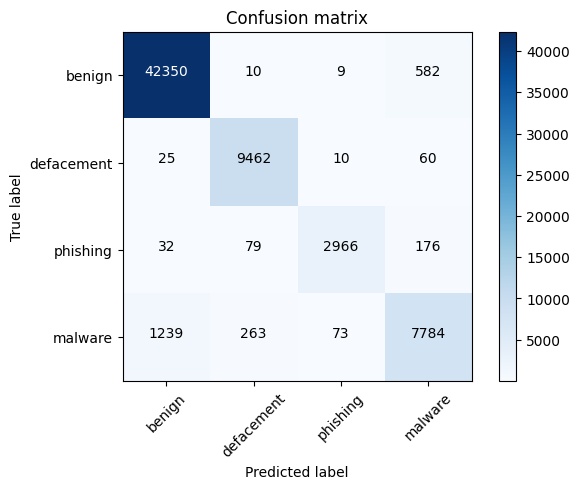

In [148]:
cm = metrics.confusion_matrix(y_test, y_predLGB, labels=[0,1,2,3])
plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [149]:
lgb_feature = lgb.feature_importances_
lgb_feature

array([  29,   59, 1015,  517,   63, 1145,   47,  134,  242,  146,  249,
        614,  539, 1038, 1527,  247, 1788,  637, 1151,  813], dtype=int32)

In [150]:
lgb_features = lgb_feature.tolist()

In [151]:
import pickle
# saving model
lgbm_pkl = "lgbm.pkl"
with open(lgbm_pkl, 'wb') as file:
    pickle.dump(LGB_C, file)

## XGBoost

In [152]:
xgb = xgb.XGBClassifier(n_estimators= 100)
xgb.fit(X_train,y_train)
y_predXGB = xgb.predict(X_test)
print(classification_report(y_test,y_predXGB))


score = metrics.accuracy_score(y_test, y_predXGB)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42951
           1       0.97      0.99      0.98      9557
           2       0.98      0.93      0.95      3253
           3       0.92      0.84      0.87      9359

    accuracy                           0.96     65120
   macro avg       0.96      0.94      0.95     65120
weighted avg       0.96      0.96      0.96     65120

accuracy:   0.964


In [153]:
xgb_acc = accuracy_score(y_test, y_predXGB)
xgb_acc

0.9637285012285012

In [154]:
xgb_f1_macro = f1_score(y_test, y_predXGB, average='macro')
xgb_f1_macro

0.9473674935890886

In [155]:
xgb_f1_micro = f1_score(y_test, y_predXGB, average='micro')
xgb_f1_micro

0.9637285012285012

In [156]:
xgb_f1_w = f1_score(y_test, y_predXGB, average='weighted')
xgb_f1_w

0.9630420244049551

In [157]:
new_eval = {'Model': 'XGB','Accuracy': xgb_acc, 'F1-macro': xgb_f1_macro, 'F1-micro': xgb_f1_micro, 'F1-weighted': xgb_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


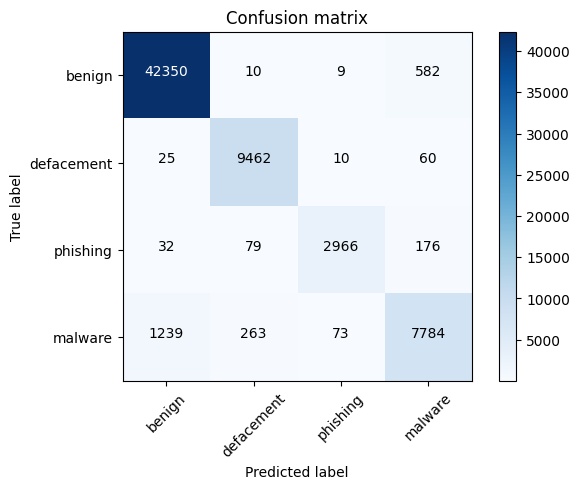

In [158]:
CM=confusion_matrix(y_test,y_predXGB,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [159]:
xgb_feature = xgb.feature_importances_
xgb_features = xgb_feature.tolist()

In [160]:
import pickle
# saving model
xgb_pkl = "xgb.pkl"
with open(xgb_pkl, 'wb') as file:
    pickle.dump(xgb, file)

## Gradient Boosting

In [161]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbdt.fit(X_train,y_train)
y_predGBDT = gbdt.predict(X_test)
print(classification_report(y_test,y_predGBDT))

score = metrics.accuracy_score(y_test, y_predGBDT)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     42951
           1       0.91      0.97      0.94      9557
           2       0.93      0.81      0.86      3253
           3       0.89      0.75      0.81      9359

    accuracy                           0.94     65120
   macro avg       0.92      0.88      0.90     65120
weighted avg       0.94      0.94      0.94     65120

accuracy:   0.940


In [162]:
gbdt_acc = accuracy_score(y_test, y_predGBDT)
gbdt_acc

0.940279484029484

In [163]:
gbdt_f1_macro = f1_score(y_test, y_predGBDT, average='macro')
gbdt_f1_macro

0.8958569066528521

In [164]:
gbdt_f1_micro = f1_score(y_test, y_predGBDT, average='micro')
gbdt_f1_micro

0.940279484029484

In [165]:
gbdt_f1_w = f1_score(y_test, y_predGBDT, average='weighted')
gbdt_f1_w

0.9382566539603268

In [166]:
new_eval = {'Model': 'GBDT','Accuracy': gbdt_acc, 'F1-macro': gbdt_f1_macro, 'F1-micro': gbdt_f1_micro, 'F1-weighted': gbdt_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


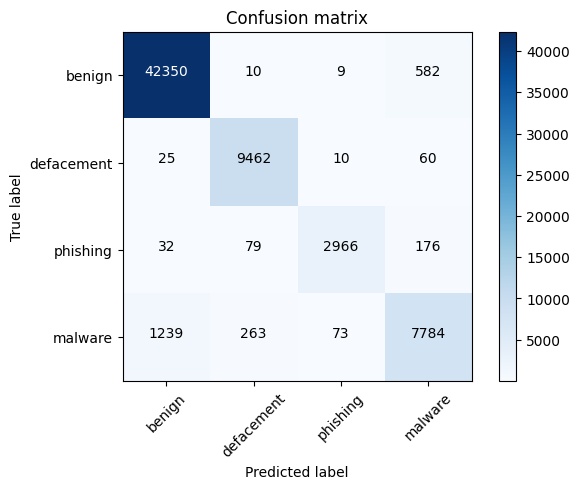

In [167]:
CM=confusion_matrix(y_test,y_predGBDT,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [168]:
gbdt_feature = gbdt.feature_importances_
gbdt_features = gbdt_feature.tolist()

In [169]:
import pickle
# saving model
gbdt_pkl = "gbdt.pkl"
with open(gbdt_pkl, 'wb') as file:
    pickle.dump(gbdt, file)

## Random Forest

In [170]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_predRF = rf.predict(X_test)
print(classification_report(y_test,y_predRF))

score = metrics.accuracy_score(y_test, y_predRF)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42951
           1       0.98      1.00      0.99      9557
           2       0.99      0.95      0.97      3253
           3       0.91      0.86      0.89      9359

    accuracy                           0.97     65120
   macro avg       0.96      0.95      0.96     65120
weighted avg       0.97      0.97      0.97     65120

accuracy:   0.967


In [171]:
rf_acc = accuracy_score(y_test, y_predRF)
rf_acc

0.9672604422604423

In [172]:
rf_f1_macro = f1_score(y_test, y_predRF, average='macro')
rf_f1_macro

0.9553948907852596

In [173]:
rf_f1_micro = f1_score(y_test, y_predRF, average='micro')
rf_f1_micro

0.9672604422604423

In [174]:
rf_f1_w = f1_score(y_test, y_predRF, average='weighted')
rf_f1_w

0.9669046339843859

In [175]:
new_eval = {'Model': 'RF','Accuracy': rf_acc, 'F1-macro': rf_f1_macro, 'F1-micro': rf_f1_micro, 'F1-weighted': rf_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


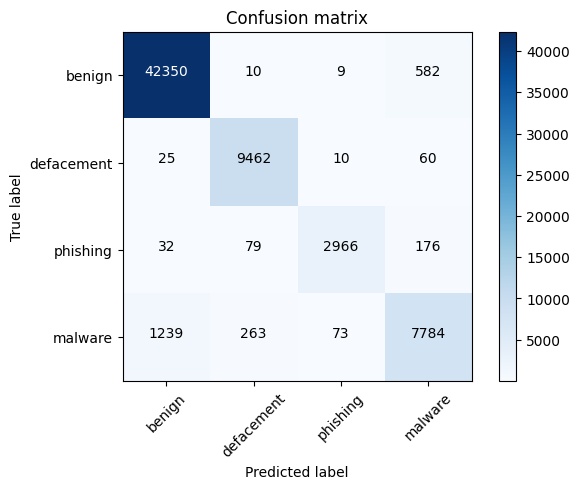

In [176]:
CM=confusion_matrix(y_test,y_predRF,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [177]:
rf_feature = rf.feature_importances_
rf_features = rf_feature.tolist()

In [178]:
import pickle
# saving model
rf_pkl = "rf.pkl"
with open(rf_pkl, 'wb') as file:
    pickle.dump(rf, file)

# Plotting Feature Importances

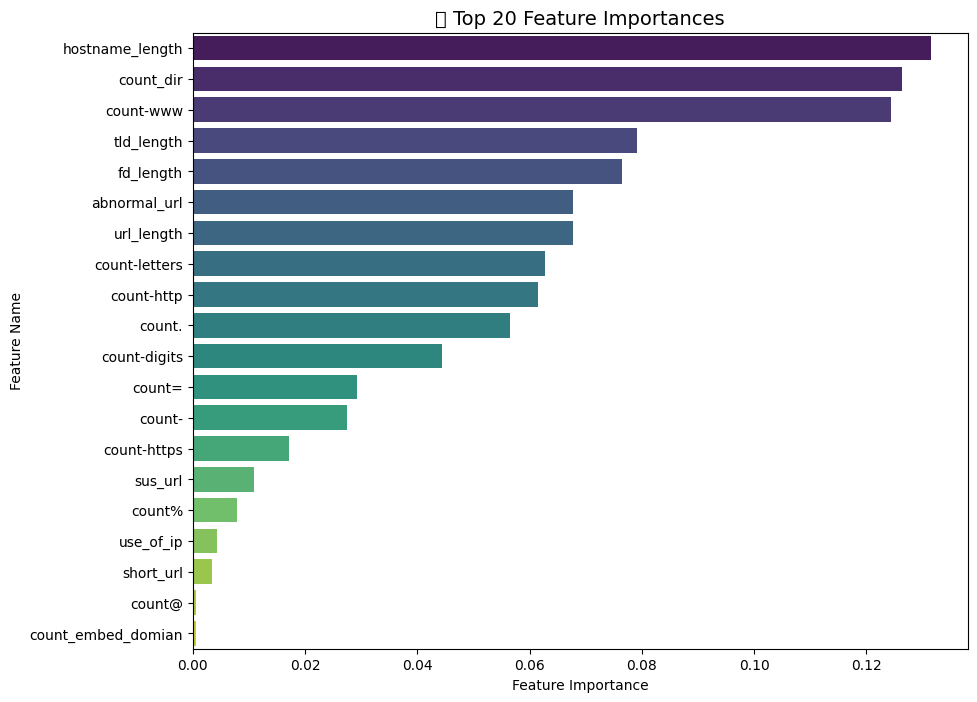

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ensure matplotlib inline for Jupyter/Colab
%matplotlib inline

def plot_feature_importance(model, X_test):
    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Feature importance': model.feature_importances_
    })

    # Sort by importance (descending) and select top 20 features
    feature_importance = feature_importance.sort_values(by='Feature importance', ascending=False).head(20)

    # Plot the feature importance
    plt.figure(figsize=(10, 8))
    plt.title('🔍 Top 20 Feature Importances', fontsize=14)
    sns.barplot(y='Feature', x='Feature importance', data=feature_importance, orient='h', palette='viridis')

    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.show()

# Call function using your trained Random Forest model
plot_feature_importance(rf, X_test)


# Final Result

In [182]:
eval_df.sort_values(by=['F1-weighted','Accuracy'], ascending=False)

,Model,Accuracy,F1-macro,F1-micro,F1-weighted
3,RF,0.967260,0.955395,0.967260,0.966905
1,XGB,0.963729,0.947367,0.963729,0.963042
0,LGBM,0.960719,0.940433,0.960719,0.960017
2,GBDT,0.940279,0.895857,0.940279,0.938257


In [183]:
eval_df.to_csv('./eval-df.csv')

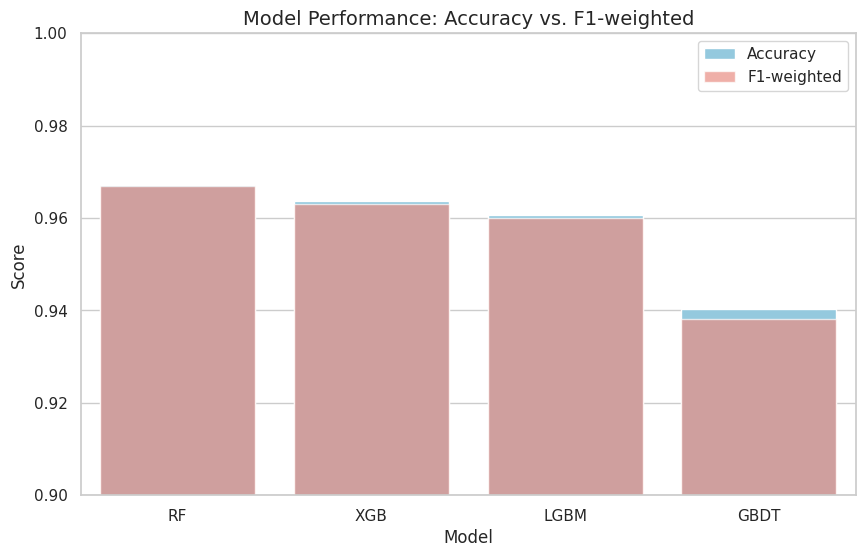

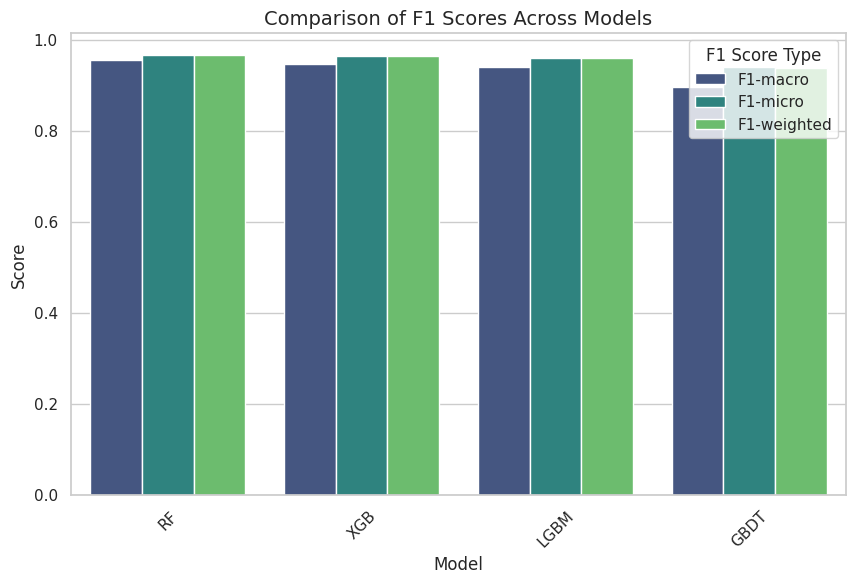

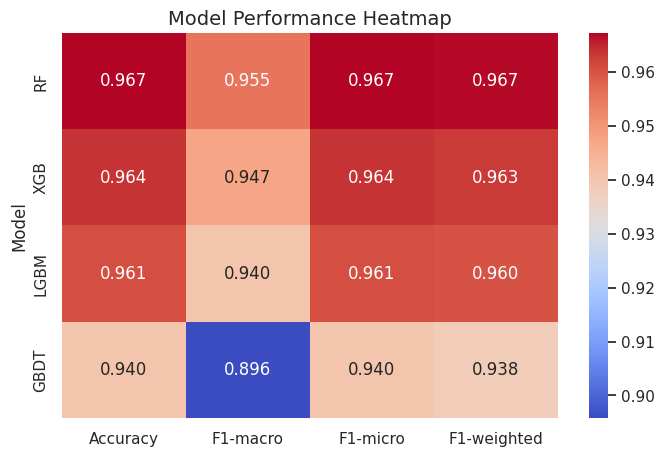

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_eval_results(eval_df):
    sns.set(style="whitegrid")

    # Sorting for better visualization
    eval_df = eval_df.sort_values(by=['F1-weighted', 'Accuracy'], ascending=False)

    # Plot Accuracy and F1-weighted Score
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Accuracy', data=eval_df, color='skyblue', label="Accuracy")
    sns.barplot(x='Model', y='F1-weighted', data=eval_df, color='salmon', alpha=0.7, label="F1-weighted")

    plt.title("Model Performance: Accuracy vs. F1-weighted", fontsize=14)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend()
    plt.ylim(0.9, 1.0)  # Adjust based on range
    plt.show()

    # Grouped Bar Chart for all F1 Scores
    f1_metrics = ['F1-macro', 'F1-micro', 'F1-weighted']
    eval_long = eval_df.melt(id_vars=["Model"], value_vars=f1_metrics, var_name="Metric", value_name="Value")

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Model", y="Value", hue="Metric", data=eval_long, palette="viridis")

    plt.title("Comparison of F1 Scores Across Models", fontsize=14)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend(title="F1 Score Type")
    plt.xticks(rotation=45)
    plt.show()

    # Heatmap for all metrics
    plt.figure(figsize=(8, 5))
    sns.heatmap(eval_df.set_index("Model"), annot=True, cmap="coolwarm", fmt=".3f")
    plt.title("Model Performance Heatmap", fontsize=14)
    plt.show()

# Example usage
visualize_eval_results(eval_df)


**USER INTERFACE IMPLEMENTATION**

In [13]:
import gradio as gr
import pandas as pd
import joblib
import re
import matplotlib.pyplot as plt
import numpy as np

# Load your models - only load once when the app starts
try:
    rf_model = joblib.load('rf.pkl')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    rf_model = None

# For debugging - show actual feature values
def debug_features(features, feature_names):
    for name, value in zip(feature_names, features):
        print(f"{name}: {value}")

# Feature extraction function - rewritten to match training data exactly
def extract_features(url):
    """
    Extract exactly the same features used in the training data.
    Make sure these match how your x_train.csv was created.
    """
    # Convert URL to lowercase for consistent feature extraction
    url = url.lower()

    features = []

    # 1. use_of_ip: Check for IP address
    features.append(1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) else 0)

    # 2. abnormal_url: Check for @ symbol or double slash in wrong position
    features.append(1 if '@' in url or ('//' in url.split('/', 1)[1] if '/' in url.split('/', 1)[0] else False) else 0)

    # 3. count.: Number of dots
    features.append(url.count('.'))

    # 4. count-www: Number of 'www' occurrences
    features.append(url.count('www'))

    # 5. count@: Number of @ symbols
    features.append(url.count('@'))

    # 6. count_dir: Number of directories (/ after domain)
    try:
        domain_part = url.split('//', 1)[1] if '//' in url else url
        directory_count = domain_part.count('/') - 1 if '/' in domain_part else 0
        features.append(max(0, directory_count))
    except:
        features.append(0)

    # 7. count_embed_domian: Number of embedded domains
    features.append(url.count('http') - 1 if url.count('http') > 1 else 0)

    # 8. short_url: Is it a shortened URL
    short_url_services = ['bit.ly', 'tinyurl', 't.co', 'goo.gl', 'is.gd', 'cli.gs', 'ow.ly', 'rebrandly']
    features.append(1 if any(service in url for service in short_url_services) else 0)

    # 9. count-https: Number of 'https' occurrences
    features.append(url.count('https'))

    # 10. count-http: Number of 'http' occurrences
    features.append(url.count('http'))

    # 11. count%: Number of % symbols
    features.append(url.count('%'))

    # 12. count-: Number of hyphens
    features.append(url.count('-'))

    # 13. count=: Number of equal signs
    features.append(url.count('='))

    # 14. url_length: Length of URL
    features.append(len(url))

    # 15. hostname_length: Length of hostname
    try:
        hostname = url.split('//', 1)[1].split('/', 1)[0] if '//' in url else url.split('/', 1)[0]
        features.append(len(hostname))
    except:
        features.append(0)

    # 16. sus_url: Contains suspicious words
    suspicious_words = ['secure', 'account', 'webscr', 'login', 'ebayisapi', 'signin', 'banking', 'confirm']
    features.append(1 if any(word in url for word in suspicious_words) else 0)

    # 17. fd_length: First directory length
    try:
        path = url.split('//', 1)[1].split('/', 1)[1] if '//' in url and '/' in url.split('//', 1)[1] else ""
        fd_length = len(path.split('/', 1)[0]) if path and '/' in path else len(path)
        features.append(fd_length)
    except:
        features.append(0)

    # 18. tld_length: TLD length
    try:
        hostname = url.split('//', 1)[1].split('/', 1)[0] if '//' in url else url.split('/', 1)[0]
        tld = hostname.split('.')[-1] if '.' in hostname else ""
        features.append(len(tld))
    except:
        features.append(0)

    # 19. count-digits: Count of digits
    features.append(sum(c.isdigit() for c in url))

    # 20. count-letters: Count of letters
    features.append(sum(c.isalpha() for c in url))

    return features

# Function to test with known samples from your dataset
def test_with_samples():
    # Add sample URLs that you know should be classified correctly
    samples = {
        "https://www.google.com": "Benign",  # Safe URL
        "https://www.paypal.com": "Benign",  # Safe URL
        "http://paypal.com.securelogin.net": "Phishing",  # Phishing example
        "http://download.malware.test/test.exe": "Malware",  # Malware example
    }

    results = {}
    for url, expected in samples.items():
        features = extract_features(url)
        feature_names = ['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
                      'count_dir', 'count_embed_domian', 'short_url', 'count-https',
                      'count-http', 'count%', 'count-', 'count=', 'url_length',
                      'hostname_length', 'sus_url', 'fd_length', 'tld_length',
                      'count-digits', 'count-letters']

        features_df = pd.DataFrame([features], columns=feature_names)
        prediction = rf_model.predict(features_df)[0]
        categories = {0: "Benign", 1: "Phishing", 2: "Malware", 3: "Defacement"}
        result = categories.get(prediction, "Unknown")
        results[url] = result

    return results

# Function to predict URL type - fixed version
def analyze_url(url):
    if not url:
        return None, "Please enter a URL to analyze", "", ""

    if rf_model is None:
        return None, "Model not loaded. Please check the file path.", "", ""

    try:
        # Extract features
        features = extract_features(url)
        feature_names = ['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
                        'count_dir', 'count_embed_domian', 'short_url', 'count-https',
                        'count-http', 'count%', 'count-', 'count=', 'url_length',
                        'hostname_length', 'sus_url', 'fd_length', 'tld_length',
                        'count-digits', 'count-letters']

        # Uncomment this line to debug feature extraction
        # debug_features(features, feature_names)

        features_df = pd.DataFrame([features], columns=feature_names)

        # Get raw probabilities first
        probabilities = rf_model.predict_proba(features_df)[0]

        # Make prediction - taking highest probability class
        prediction = np.argmax(probabilities)

        # Map prediction to category
        categories = {0: "Benign", 1: "Phishing", 2: "Malware", 3: "Defacement"}
        result = categories.get(prediction, "Unknown")

        # Prepare result styling
        if result == "Benign":
            icon = "✅"
            color = "#4CAF50"  # Green
            message = f"{icon} SAFE: This URL appears to be legitimate."
        elif result == "Phishing":
            icon = "⚠️"
            color = "#FF9800"  # Orange
            message = f"{icon} CAUTION: This URL is likely a phishing attempt!"
        elif result == "Malware":
            icon = "🛑"
            color = "#F44336"  # Red
            message = f"{icon} DANGER: This URL likely contains malware!"
        elif result == "Defacement":
            icon = "⚠️"
            color = "#9C27B0"  # Purple
            message = f"{icon} WARNING: This URL may lead to a defaced website!"
        else:
            icon = "❓"
            color = "#607D8B"  # Grey
            message = f"{icon} UNKNOWN: Could not classify this URL."

        # Create visualization
        labels = ["Benign", "Phishing", "Malware", "Defacement"]
        plt.figure(figsize=(10, 5))
        colors = ['#4CAF50', '#FF9800', '#F44336', '#9C27B0']
        bars = plt.bar(labels, probabilities, color=colors)
        plt.xlabel('URL Type')
        plt.ylabel('Probability')
        plt.title('URL Classification Confidence Levels')
        plt.ylim(0, 1)

        # Add values on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('probability_chart.png')
        plt.close()

        # Show top features contributing to the classification
        feature_importance = {}
        if hasattr(rf_model, 'feature_importances_'):
            importance = rf_model.feature_importances_
            for feat, imp in zip(feature_names, importance):
                feature_importance[feat] = imp

            # Sort by importance
            top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:5]
            top_feature_str = "<br>".join([f"• {feat}: {imp:.4f}" for feat, imp in top_features])
        else:
            top_feature_str = "Feature importance not available"

        detailed_result = f"""
        <div style='padding: 20px; border-radius: 10px; background-color: {color}25;'>
            <h2 style='color: {color}; font-family: Arial;'>{result}</h2>
            <p style='font-size: 16px;'>{message}</p>
            <p style='font-size: 14px;'>Analyzed URL: <code>{url}</code></p>
            <div style='margin-top: 15px;'>
                <p style='font-size: 14px; font-weight: bold;'>Top contributing features:</p>
                <p style='font-size: 13px;'>{top_feature_str}</p>
            </div>
        </div>
        """

        return 'probability_chart.png', message, detailed_result, color

    except Exception as e:
        return None, f"Error analyzing URL: {str(e)}", "", ""

# Fix model mapping if needed
def fix_model_label_mapping():
    """
    Use this function if the model's class index mapping is different from what you expect.
    For example, if "Benign" is actually class 1 instead of 0.
    """
    # This is just an example - adjust based on how your model was trained
    new_mapping = {
        0: "Benign",      # If 0 is actually Benign
        1: "Phishing",    # If 1 is actually Phishing
        2: "Malware",     # If 2 is actually Malware
        3: "Defacement"   # If 3 is actually Defacement
    }

    # Test with some known URLs to verify mapping
    test_results = test_with_samples()
    print("Test results with current mapping:")
    for url, result in test_results.items():
        print(f"{url}: {result}")

    return new_mapping

# Create Gradio interface with warm colors
def create_interface():
    with gr.Blocks(css="""
        .gradio-container {
            background: linear-gradient(135deg, #fff8e1 0%, #ffcc80 100%);
        }
        .url-input input {
            border-radius: 10px !important;
            border: 2px solid #ff9800 !important;
            padding: 15px !important;
            font-size: 16px !important;
            background-color: #fff8e1 !important;
        }
        .analyze-btn {
            background-color: #ff9800 !important;
            color: white !important;
            border-radius: 10px !important;
            padding: 10px 20px !important;
            font-size: 16px !important;
            transition: transform 0.2s !important;
            box-shadow: 0 4px 8px rgba(255, 152, 0, 0.3) !important;
        }
        .analyze-btn:hover {
            transform: scale(1.05) !important;
            background-color: #f57c00 !important;
        }
        .result-area {
            border-radius: 15px !important;
            box-shadow: 0 8px 16px rgba(0,0,0,0.1) !important;
            background-color: white !important;
            padding: 20px !important;
            margin-top: 20px !important;
        }
        h1, h2, h3 {
            font-family: 'Segoe UI', Arial, sans-serif !important;
        }
        .sample-btn {
            background-color: #ffb74d !important;
            color: #333 !important;
            border-radius: 8px !important;
            font-size: 14px !important;
            margin: 0 5px !important;
            transition: all 0.2s !important;
        }
        .sample-btn:hover {
            background-color: #ffa726 !important;
            transform: translateY(-2px) !important;
        }
    """) as demo:
        gr.HTML("""
        <div style="text-align: center; margin-bottom: 20px;">
            <h1 style="color: #e65100; font-size: 36px; text-shadow: 2px 2px 4px rgba(230, 81, 0, 0.2);">
                🛡️ URL Security Scanner
            </h1>
            <p style="font-size: 18px; color: #ff6f00;">
                Enter a URL to instantly check if it's safe or malicious
            </p>
        </div>
        """)

        with gr.Row():
            with gr.Column():
                url_input = gr.Textbox(
                    label="Enter URL to analyze",
                    placeholder="https://example.com",
                    elem_classes=["url-input"]
                )
                analyze_button = gr.Button(
                    "🔍 Scan URL Now",
                    elem_classes=["analyze-btn"]
                )

        with gr.Row(elem_classes=["result-area"]):
            with gr.Column(scale=1):
                animation_output = gr.Image(label="Threat Assessment")
            with gr.Column(scale=2):
                result_output = gr.Textbox(label="Quick Result")
                detailed_html = gr.HTML(label="")
                color_indicator = gr.Textbox(visible=False)

        analyze_button.click(
            analyze_url,
            inputs=[url_input],
            outputs=[animation_output, result_output, detailed_html, color_indicator]
        )

        # Add sample URL buttons for testing
        with gr.Row():
            gr.HTML("<p style='margin-top: 15px; font-weight: bold;'>Test with sample URLs:</p>")

        with gr.Row():
            gr.Button("Safe URL Example", elem_classes=["sample-btn"]).click(
                lambda: "https://www.google.com",
                outputs=url_input
            )
            gr.Button("Phishing URL Example", elem_classes=["sample-btn"]).click(
                lambda: "http://paypal.com.secure-login.ru",
                outputs=url_input
            )
            gr.Button("Malware URL Example", elem_classes=["sample-btn"]).click(
                lambda: "http://downloadfree.malicioussite.com/trojan.exe",
                outputs=url_input
            )
            gr.Button("Defacement URL Example", elem_classes=["sample-btn"]).click(
                lambda: "http://hacked.website.com/defaced.html",
                outputs=url_input
            )

        gr.HTML("""
        <div style="text-align: center; margin-top: 30px; padding: 15px; border-top: 1px solid #ffe0b2;">
            <p style="font-size: 14px; color: #e65100;">
                Instant URL scanning powered by advanced machine learning
                <br>Built for speed and accuracy
            </p>
        </div>
        """)

    return demo

# Launch the application
if __name__ == "__main__":
    # Uncomment this line to test and fix model mapping if needed
    # fix_model_label_mapping()

    # Load model once at startup for faster predictions
    create_interface().launch()

Model loaded successfully!
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://06bf6617a636df30a1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [16]:
import gradio as gr
import pandas as pd
import joblib
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Load your models - only load once when the app starts
try:
    rf_model = joblib.load('/content/rf.pkl')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    rf_model = None

# Feature extraction function
def extract_features(url):
    url = url.lower()
    features = []

    # 1. use_of_ip: Check for IP address
    features.append(1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) else 0)

    # 2. abnormal_url: Check for @ symbol or double slash in wrong position
    features.append(1 if '@' in url or ('//' in url.split('/', 1)[1] if '/' in url.split('/', 1)[0] else False) else 0)

    # 3. count.: Number of dots
    features.append(url.count('.'))

    # 4. count-www: Number of 'www' occurrences
    features.append(url.count('www'))

    # 5. count@: Number of @ symbols
    features.append(url.count('@'))

    # 6. count_dir: Number of directories (/ after domain)
    try:
        domain_part = url.split('//', 1)[1] if '//' in url else url
        directory_count = domain_part.count('/') - 1 if '/' in domain_part else 0
        features.append(max(0, directory_count))
    except:
        features.append(0)

    # 7. count_embed_domian: Number of embedded domains
    features.append(url.count('http') - 1 if url.count('http') > 1 else 0)

    # 8. short_url: Is it a shortened URL
    short_url_services = ['bit.ly', 'tinyurl', 't.co', 'goo.gl', 'is.gd', 'cli.gs', 'ow.ly', 'rebrandly']
    features.append(1 if any(service in url for service in short_url_services) else 0)

    # 9. count-https: Number of 'https' occurrences
    features.append(url.count('https'))

    # 10. count-http: Number of 'http' occurrences
    features.append(url.count('http'))

    # 11. count%: Number of % symbols
    features.append(url.count('%'))

    # 12. count-: Number of hyphens
    features.append(url.count('-'))

    # 13. count=: Number of equal signs
    features.append(url.count('='))

    # 14. url_length: Length of URL
    features.append(len(url))

    # 15. hostname_length: Length of hostname
    try:
        hostname = url.split('//', 1)[1].split('/', 1)[0] if '//' in url else url.split('/', 1)[0]
        features.append(len(hostname))
    except:
        features.append(0)

    # 16. sus_url: Contains suspicious words
    suspicious_words = ['secure', 'account', 'webscr', 'login', 'ebayisapi', 'signin', 'banking', 'confirm']
    features.append(1 if any(word in url for word in suspicious_words) else 0)

    # 17. fd_length: First directory length
    try:
        path = url.split('//', 1)[1].split('/', 1)[1] if '//' in url and '/' in url.split('//', 1)[1] else ""
        fd_length = len(path.split('/', 1)[0]) if path and '/' in path else len(path)
        features.append(fd_length)
    except:
        features.append(0)

    # 18. tld_length: TLD length
    try:
        hostname = url.split('//', 1)[1].split('/', 1)[0] if '//' in url else url.split('/', 1)[0]
        tld = hostname.split('.')[-1] if '.' in hostname else ""
        features.append(len(tld))
    except:
        features.append(0)

    # 19. count-digits: Count of digits
    features.append(sum(c.isdigit() for c in url))

    # 20. count-letters: Count of letters
    features.append(sum(c.isalpha() for c in url))

    return features

# Function to analyze URL
def analyze_url(url):
    if not url:
        return None, "Please enter a URL to analyze", "", ""

    if rf_model is None:
        return None, "Model not loaded. Please check the file path.", "", ""

    try:
        # Extract features
        features = extract_features(url)
        feature_names = ['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
                        'count_dir', 'count_embed_domian', 'short_url', 'count-https',
                        'count-http', 'count%', 'count-', 'count=', 'url_length',
                        'hostname_length', 'sus_url', 'fd_length', 'tld_length',
                        'count-digits', 'count-letters']

        features_df = pd.DataFrame([features], columns=feature_names)

        # Get raw probabilities first
        probabilities = rf_model.predict_proba(features_df)[0]

        # Make prediction - taking highest probability class
        prediction = np.argmax(probabilities)

        # Map prediction to category
        categories = {0: "Benign", 1: "Phishing", 2: "Malware", 3: "Defacement"}
        result = categories.get(prediction, "Unknown")

        # Prepare result styling
        if result == "Benign":
            icon = "✅"
            color = "#4CAF50"  # Green
            message = f"{icon} SAFE: This URL appears to be legitimate."
        elif result == "Phishing":
            icon = "⚠️"
            color = "#FF9800"  # Orange
            message = f"{icon} CAUTION: This URL is likely a phishing attempt!"
        elif result == "Malware":
            icon = "🛑"
            color = "#F44336"  # Red
            message = f"{icon} DANGER: This URL likely contains malware!"
        elif result == "Defacement":
            icon = "⚠️"
            color = "#9C27B0"  # Purple
            message = f"{icon} WARNING: This URL may lead to a defaced website!"
        else:
            icon = "❓"
            color = "#607D8B"  # Grey
            message = f"{icon} UNKNOWN: Could not classify this URL."

        # Create visualization
        labels = ["Benign", "Phishing", "Malware", "Defacement"]
        plt.figure(figsize=(10, 5))
        colors = ['#4CAF50', '#FF9800', '#F44336', '#9C27B0']
        bars = plt.bar(labels, probabilities, color=colors)
        plt.xlabel('URL Type')
        plt.ylabel('Probability')
        plt.title('URL Classification Confidence Levels')
        plt.ylim(0, 1)

        # Add values on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('probability_chart.png')
        plt.close()

        # Show top features contributing to the classification
        feature_importance = {}
        if hasattr(rf_model, 'feature_importances_'):
            importance = rf_model.feature_importances_
            for feat, imp in zip(feature_names, importance):
                feature_importance[feat] = imp

            # Sort by importance
            top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:5]
            top_feature_str = "<br>".join([f"• {feat}: {imp:.4f}" for feat, imp in top_features])
        else:
            top_feature_str = "Feature importance not available"

        detailed_result = f"""
        <div style='padding: 20px; border-radius: 10px; background-color: {color}25;'>
            <h2 style='color: {color}; font-family: Arial;'>{result}</h2>
            <p style='font-size: 16px;'>{message}</p>
            <p style='font-size: 14px;'>Analyzed URL: <code>{url}</code></p>
            <div style='margin-top: 15px;'>
                <p style='font-size: 14px; font-weight: bold;'>Top contributing features:</p>
                <p style='font-size: 13px;'>{top_feature_str}</p>
            </div>
        </div>
        """

        return 'probability_chart.png', message, detailed_result, color

    except Exception as e:
        return None, f"Error analyzing URL: {str(e)}", "", ""

# Create Gradio interface
def create_interface():
    with gr.Blocks(css="""
        .gradio-container {
            background: linear-gradient(135deg, #fff8e1 0%, #ffcc80 100%);
        }
        .url-input input {
            border-radius: 10px !important;
            border: 2px solid #ff9800 !important;
            padding: 15px !important;
            font-size: 16px !important;
            background-color: #fff8e1 !important;
        }
        .analyze-btn {
            background-color: #ff9800 !important;
            color: white !important;
            border-radius: 10px !important;
            padding: 10px 20px !important;
            font-size: 16px !important;
            transition: transform 0.2s !important;
            box-shadow: 0 4px 8px rgba(255, 152, 0, 0.3) !important;
        }
        .analyze-btn:hover {
            transform: scale(1.05) !important;
            background-color: #f57c00 !important;
        }
        .result-area {
            border-radius: 15px !important;
            box-shadow: 0 8px 16px rgba(0,0,0,0.1) !important;
            background-color: white !important;
            padding: 20px !important;
            margin-top: 20px !important;
        }
        h1, h2, h3 {
            font-family: 'Segoe UI', Arial, sans-serif !important;
        }
        .sample-btn {
            background-color: #ffb74d !important;
            color: #333 !important;
            border-radius: 8px !important;
            font-size: 14px !important;
            margin: 0 5px !important;
            transition: all 0.2s !important;
        }
        .sample-btn:hover {
            background-color: #ffa726 !important;
            transform: translateY(-2px) !important;
        }
    """) as demo:
        gr.HTML("""
        <div style="text-align: center; margin-bottom: 20px;">
            <h1 style="color: #e65100; font-size: 36px; text-shadow: 2px 2px 4px rgba(230, 81, 0, 0.2);">
                🛡️ URL Security Scanner
            </h1>
            <p style="font-size: 18px; color: #ff6f00;">
                Enter a URL to instantly check if it's safe or malicious
            </p>
        </div>
        """)

        with gr.Row():
            with gr.Column():
                url_input = gr.Textbox(
                    label="Enter URL to analyze",
                    placeholder="https://example.com",
                    elem_classes=["url-input"]
                )
                analyze_button = gr.Button(
                    "🔍 Scan URL Now",
                    elem_classes=["analyze-btn"]
                )

        with gr.Row(elem_classes=["result-area"]):
            with gr.Column(scale=1):
                animation_output = gr.Image(label="Threat Assessment")
            with gr.Column(scale=2):
                result_output = gr.Textbox(label="Quick Result")
                detailed_html = gr.HTML(label="")
                color_indicator = gr.Textbox(visible=False)

        analyze_button.click(
            analyze_url,
            inputs=[url_input],
            outputs=[animation_output, result_output, detailed_html, color_indicator]
        )

        # Add sample URL buttons for testing
        with gr.Row():
            gr.HTML("<p style='margin-top: 15px; font-weight: bold;'>Test with sample URLs:</p>")

        with gr.Row():
            gr.Button("Safe URL Example", elem_classes=["sample-btn"]).click(
                lambda: "https://www.google.com",
                outputs=url_input
            )
            gr.Button("Phishing URL Example", elem_classes=["sample-btn"]).click(
                lambda: "http://paypal.com.secure-login.ru",
                outputs=url_input
            )
            gr.Button("Malware URL Example", elem_classes=["sample-btn"]).click(
                lambda: "http://downloadfree.malicioussite.com/trojan.exe",
                outputs=url_input
            )
            gr.Button("Defacement URL Example", elem_classes=["sample-btn"]).click(
                lambda: "http://hacked.website.com/defaced.html",
                outputs=url_input
            )

        gr.HTML("""
        <div style="text-align: center; margin-top: 30px; padding: 15px; border-top: 1px solid #ffe0b2;">
            <p style="font-size: 14px; color: #e65100;">
                Instant URL scanning powered by advanced machine learning
                <br>Built for speed and accuracy
            </p>
        </div>
        """)

    return demo

# Launch the application
if __name__ == "__main__":
    create_interface().launch()

Model loaded successfully!
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://661368b34b526db26b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
